In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import seaborn as sns

In [52]:
def cp_ig_coeff_pseudo(kw , w): #T IN KELVIN  #joule/mole
    a0 = -1.41779 + 0.11828 * kw
    a1 = -1 * (6.99724 - 8.69326*kw + 0.27715*kw**2) * 10**(-4)
    a2 = -2.2582 * 10**(-6)

    b0 = 1.09223 - 2.48245*w
    b1 = -1 * (3.434 - 7.14*w) * 10**(-3)
    b2 = -1 * (7.2661 - 9.2561*w) * 10**(-7)

    c = ( ( (12.8-kw)*(10-kw) ) / (10*w) )**2

    return a0 , a1 , a2 , b0 , b1 , b2 , c

def cp_liq_coeff_pseudo(kw , sg ): #kj/kg.k ----> convert it to kmole then multiply by mwt ---> kj/kmole.k
   
   a1 = -4.90383 + kw*(0.099319 + 0.104281*sg) + ((4.81407 - 0.194833*kw)/sg)
   a2 = (7.53621 + 6.21461 * kw) * (1.12172 - (0.27634/sg)) * 10**(-4)
   a3 = -1*(1.35652 + 1.11863*kw)* (2.9027 - (0.70958/sg)) * 10**(-7)
   
   
   return  a1 , a2 , a3

In [53]:
def system(w , y  , T_opt , Vo_liq):
#هنشوف حوار ال RESIDUE
    FF_vap , FD_vap , FK_vap  ,FN_vap , FG_vap , FF_liq , FD_liq , FK_liq , FN_liq , FG_liq , p  ,T ,F_H2 = y

  
    po = 129.5  #bar
    To = T_opt #k
    
    ro_bulk = 654
    phai = 0.7384
    ro_cat = ro_bulk / (1-phai)
    F_tot_o_vap = 3594.723146
    vo_vap = 1559 #m3/hr
    vo_liq = Vo_liq  #m3/hr
    
    CT_o_vap = 2.307 #kmole/m3
    FI_vap = 300.2924055 #kmole/hr

    Residue_vap = 0.005588344
    Residue_liq = 4.745247617
    #vap phase:
   #------------ 
    #CT_o_vap = (po*101325) / (8314 * (to + 273.15)) #po bar , to deg c  pa/(J/mole.k) * k 
    F_tot_vap = FF_vap + FD_vap + FN_vap + FK_vap  +FG_vap  + FI_vap  + F_H2 + Residue_vap  #kmole/hr

    C_F_vap   = CT_o_vap * FF_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3
    C_N_vap   = CT_o_vap * FN_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3
    C_D_vap   = CT_o_vap * FD_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3
    C_K_vap   = CT_o_vap * FK_vap   * p * To / (F_tot_vap * po * T)  #kmole/m3

    

    #MWTs
    MWT_VGO = 447.8479509
    MWT_N   = 114.9170391
    MWT_D   = 292.7362979
    MWT_K   = 170.23913
    MWT_G   = 16.56482354
    MWT_R   = 759.9991037

    K_FD = 4           * np.exp( (23.51 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_DK = 0.862       * np.exp( (45.39 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_FK = 1.01        * np.exp( (49.63 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_FN = 2.18*10**-5 * np.exp( (41.34 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_FG = 0.745       * np.exp( (5.61  * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_DN = 2.53        * np.exp( (45.72 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_DG = 8.04*10**-29* np.exp( (87.38 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_KN = 0.54        * np.exp( (22.13 * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_KG = 2.08*10**-3 * np.exp( (0.13  * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    K_NG = 12.43       * np.exp( (0     * 10**3 / 1.987) * (  ( T - (390+273.15) ) / ( T * (390+273.15) )  ) )
    

    #rate equations for vapor phase
    r_F_vap = -(C_F_vap) * (K_FD + K_FK + K_FG) / ro_bulk
    r_D_vap = (K_FD * (C_F_vap ) - K_DK * (C_D_vap ) - K_DN * (C_D_vap )) / ro_bulk
    r_K_vap = (K_FK * (C_F_vap ) + K_DK * (C_D_vap ) - K_KN * (C_K_vap )) / ro_bulk
    r_N_vap = (K_FN * (C_F_vap ) + K_DN * (C_D_vap ) + K_KN * (C_K_vap ) - K_NG * (C_N_vap)) / ro_bulk
    r_G_vap = (K_FG * (C_F_vap ) + K_DG * (C_D_vap ) + K_KG * (C_K_vap ) + K_NG * (C_N_vap)) / ro_bulk
    
   #mole balance for vapors
    dF_F_vap_dw = r_F_vap
    dF_D_vap_dw = r_D_vap
    dF_K_vap_dw = r_K_vap
    dF_N_vap_dw = r_N_vap
    dF_G_vap_dw = r_G_vap



    C_F_liq   = FF_liq / vo_liq  #kmole/m3
    C_N_liq   = FN_liq / vo_liq  #kmole/m3
    C_D_liq   = FD_liq / vo_liq  #kmole/m3
    C_K_liq   = FK_liq / vo_liq  #kmole/m3

    #rate equations for liq phase
    r_F_liq = -(C_F_liq) * (K_FD + K_FK + K_FG) / ro_bulk
    r_D_liq = (K_FD * (C_F_liq ) - K_DK * (C_D_liq ) - K_DN * (C_D_liq )) / ro_bulk
    r_K_liq = (K_FK * (C_F_liq ) + K_DK * (C_D_liq ) - K_KN * (C_K_liq )) / ro_bulk
    r_N_liq = (K_FN * (C_F_liq ) + K_DN * (C_D_liq ) + K_KN * (C_K_liq ) - K_NG * (C_N_liq)) / ro_bulk
    r_G_liq = (K_FG * (C_F_liq ) + K_DG * (C_D_liq ) + K_KG * (C_K_liq ) + K_NG * (C_N_liq ))/ ro_bulk

    #mole balance for liquids
    dF_F_liq_dw = r_F_liq
    dF_D_liq_dw = r_D_liq
    dF_K_liq_dw = r_K_liq
    dF_N_liq_dw = r_N_liq
    dF_G_liq_dw = r_G_liq
    
    

    #energy balance 

    a0_VGO_vap , a1_VGO_vap , a2_VGO_vap , b0_VGO_vap , b1_VGO_vap , b2_VGO_vap , c_VGO_vap = cp_ig_coeff_pseudo(kw = 11.83301505, w = 1.046734155)
    a0_D_vap , a1_D_vap , a2_D_vap , b0_D_vap , b1_D_vap , b2_D_vap , c_D_vap = cp_ig_coeff_pseudo(kw = 11.82860779, w = 0.77914103)
    a0_K_vap , a1_K_vap , a2_K_vap , b0_K_vap , b1_K_vap , b2_K_vap , c_K_vap = cp_ig_coeff_pseudo(kw = 11.93827339, w = 0.518610817)
    a0_N_vap , a1_N_vap , a2_N_vap , b0_N_vap , b1_N_vap , b2_N_vap , c_N_vap = cp_ig_coeff_pseudo(kw = 12.20555753, w = 0.345207156)
    a0_R_vap , a1_R_vap , a2_R_vap , b0_R_vap , b1_R_vap , b2_R_vap , c_R_vap = cp_ig_coeff_pseudo(kw = 11.81969833, w = 1.558194126) 

    a1_VGO_liq , a2_VGO_liq , a3_VGO_liq  = cp_liq_coeff_pseudo(kw = 11.833263  , sg = 0.922061456)  
    a1_D_liq   , a2_D_liq   , a3_D_liq    = cp_liq_coeff_pseudo(kw = 11.82860779, sg = 0.872109193)
    a1_K_liq   , a2_K_liq   , a3_K_liq    = cp_liq_coeff_pseudo(kw = 11.93827339, sg = 0.803929666)
    a1_N_liq   , a2_N_liq   , a3_N_liq    = cp_liq_coeff_pseudo(kw = 12.20555753, sg = 0.734974159)
    a1_G_liq   , a2_G_liq   , a3_G_liq    = cp_liq_coeff_pseudo(kw = 13         , sg = 0.566285714)  
    a1_R_liq   , a2_R_liq   , a3_R_liq    = cp_liq_coeff_pseudo(kw = 11.81969833, sg = 0.991019934) 
    
    octane_nbp = 125.6700073       
    hexa_nbp   = 286.7900024       
     

    
    lambda_nbp_hexa   = 51142.9 #j/mol
    lambda_nbp_octane = 34940.8 #j/mol



    lambda_transform_octane = lambda_nbp_octane *  ( (568.83 - 25)/(568.83 - octane_nbp)  )**0.38
    lambda_transform_hexa   = lambda_nbp_hexa   *  ( (720.6 - 25 )/(568.83 - hexa_nbp  )  )**0.38
    

    delta_H_ig_octane_298_T = 29.053 * (T - 298.15) + 0.5 * 0.58016   * (T**2 - 298.15**2)  - (1/3) * 5.7103e-5 * (T**3 - 298.15**3) - 0.25 * 1.955e-7 * (T**4 - 298.15**4) + 0.2 * 7.6614e-11 * (T**5 - 298.15**5)
    delta_H_ig_hexa_298_T   = 131.75 * (T - 298.15) + 0.5 * 0.67397   * (T**2 - 298.15**2)  + (1/3) * 8.7770e-4 * (T**3 - 298.15**3) - 0.25 * 1.243e-6 * (T**4 - 298.15**4) + 0.2 * 3.9785e-10 * (T**5 - 298.15**5)
    delta_H_ig_H2_298_T     = 25.399 * (T - 298.15) + 0.5 * 2.0178e-2 * (T**2 - 298.15**2)  - (1/3) * 3.8549e-5 * (T**3 - 298.15**3) + 0.25 * 3.188e-8 * (T**4 - 298.15**4) - 0.2 * 8.7585e-12 * (T**5 - 298.15**5)

    delta_heat_rxn_25_T_deg_c =2*(lambda_transform_octane + delta_H_ig_octane_298_T) - delta_H_ig_H2_298_T - (lambda_transform_hexa + delta_H_ig_hexa_298_T)

    MWT_G     = 16.56482354
    F_H2S_vap = 297.7673451
    F_NH3_vap = 2.52506041
    F_NH3_liq = 0.149586238
    F_H2S_liq = 18.06256176
    
  
    
    ro_bulk = 654
    phai = 0.7384
    ro_cat = ro_bulk / (1-phai)
   
    LHSV = 0.68 #hr-1 انا مثبتها

    alpha_ = 3441.319 - 10.762 * T - 18.906 * LHSV + 0.00854 * T**2 + 5.452 * LHSV**2 - 0.00858 * T * LHSV

    dF_H2_dw =  ( alpha_ * (2/MWT_VGO)  )  *  (r_F_liq + r_F_vap) 
    FF_vap_o= 17.40854988
    FF_liq_o= 242.4937994

    FF_consumed = FF_vap_o + FF_liq_o - FF_vap - FF_liq
    
    bast =   -(-42000 + delta_heat_rxn_25_T_deg_c ) * -(alpha_ * (2/MWT_VGO) )  * (r_F_liq + r_F_vap) 
    
    F_H2_in = 80.81982135 + 3184.765541
    F_H2_consumed = (alpha_ * (2/MWT_VGO) )  * (FF_consumed)
    F_H2    = F_H2_in - F_H2_consumed
    
    methane_cp = 38.387 -0.0744763*T  + 0.00029098*T**2 -2.63849E-07 * T**3 + 8.00679E-11*T**4


    sigma_Fi_Cpi = (F_H2)*(25.399 + 2.0178e-2 * T  - 3.8549e-5 * T**2 + 3.188e-8 * T**3 - 8.7585e-12 * T**4)
    + F_H2S_vap * (34.5234 - 0.01765 * T + 6.77e-5 * T**2 -5.3e-8 * T**3 +1.41e-11 * T**4)
    + F_NH3_vap * (27.55   - 0.025628* T + 9.9e-6   *T**2 -6.7e-9      * T**3)
    + F_NH3_liq * (20.1494 + 0.845765* T -0.00406745*T**2 +6.60687E-06 * T**3)
    + F_H2S_liq * (21.8238 + 0.774223* T -0.00420204*T**2 +7.38677E-06 * T**3)
    + FF_liq   * MWT_VGO * (a1_VGO_liq + a2_VGO_liq*T + a3_VGO_liq*T**2)     
    + FF_vap   * MWT_VGO * (a0_VGO_vap + a1_VGO_vap*T + a2_VGO_vap*T**2 - c_VGO_vap*(b0_VGO_vap + b1_VGO_vap*T +b2_VGO_vap*T**2   ) )
    + FD_liq   * MWT_D   * (a1_D_liq   + a2_D_liq*T   + a3_D_liq    *T**2)     
    + FD_vap   * MWT_D   * (a0_D_vap   + a1_D_vap*T   + a2_D_vap*T**2   - c_D_vap  *(b0_D_vap   + b1_D_vap*T   +b2_D_vap  *T**2   ) )
    + FN_liq   * MWT_N   * (a1_N_liq   + a2_N_liq*T   + a3_N_liq    *T**2)     
    + FN_vap   * MWT_N   * (a0_N_vap   + a1_N_vap*T   + a2_N_vap*T**2   - c_N_vap  *(b0_N_vap   + b1_N_vap*T   +b2_N_vap  *T**2   ) )
    + FG_liq   * MWT_G   * (a1_G_liq   + a2_G_liq*T   + a3_G_liq    *T**2)     
    + FG_vap   * methane_cp
    + FK_liq   * MWT_K   * (a1_K_liq   + a2_K_liq*T   + a3_K_liq    *T**2)
    + FK_vap   * MWT_K   * (a0_K_vap   + a1_K_vap*T   + a2_K_vap*T**2   - c_K_vap  *(b0_K_vap   + b1_K_vap*T   +b2_K_vap  *T**2   ) )
    + Residue_liq* MWT_R * (a1_R_liq   + a2_R_liq*T   + a3_R_liq    *T**2)
    + Residue_vap* MWT_R  *(a0_R_vap   + a1_R_vap*T   + a2_R_vap*T**2   - c_R_vap  *(b0_R_vap   + b1_R_vap*T   +b2_R_vap  *T**2   ) )
    
    dT_dw = bast / (sigma_Fi_Cpi )
    
    
    #Momentum balance for vapors and gases
    
    G = 2100 #lbm/hr.ft**2
    phai = 0.7384
    ro_o = 17.2305811120128 * (0.3048**3/0.4536) #lb/ft3
    gc   = 4.17*10**8 #lbm.ft/hr2.lbf
    Dp   = (1/16)/12 #ft ممكن تتعدل
    
    ro_cat = ro_bulk * (0.3048**3/0.4536) / (1-phai) #lb/ft3
    F_tot_o_vap = 3594.723146 #kmole/hr
    
    

    m_dot_vap = 5.92*10**4 #lb/h
    Ac = m_dot_vap / G #ft**2
    
    beta_o = G**2  * (1 - phai) * 1.75 / (ro_o * gc * Dp * phai**3) /(144*14.7) #atm/ft
    alpha = ( 2 * beta_o / (Ac * ro_cat * (1-phai) * po) ) / 0.4536 #kg-1
    dp_dw = -alpha * (T / To) * (F_tot_vap / F_tot_o_vap) * (po**2 / (2*p) ) #atm/kg
    

    
    return [dF_F_vap_dw , dF_D_vap_dw , dF_K_vap_dw , dF_N_vap_dw , dF_G_vap_dw , dF_F_liq_dw , dF_D_liq_dw , dF_K_liq_dw , dF_N_liq_dw , dF_G_liq_dw , dp_dw ,dT_dw ,dF_H2_dw]
    


In [54]:
P_opt = np.arange(120 , 150.5 , 0.5)
T_opt = np.arange(300+273.15 , 450+273.15 , 0.5)
Vo_liq = np.arange(50 , 205 , 5)
results = {

    "T" : [] , 
    "Vo liq" : [] ,
    "Diesel":[],
    "w" : [],
    "p_max" :[],
    "T_max" : [],
    "VGO out" : []
}

In [55]:
from tqdm import tqdm
for T_ in tqdm(T_opt, desc="Processing T_opt values"):
    
    for V_ in Vo_liq:
        
        # Initial conditions
        FF_vap_o= 17.40854988
        FD_vap_o= 3.4939349
        FN_vap_o= 4.710737381
        FG_vap_o= 79.63116174
        FK_vap_o= 6.419638388
        FH2_o   = 80.81982135 + 3184.765541
        FF_liq_o= 242.4937994
        FD_liq_o= 8.813903679
        FN_liq_o= 1.23282972
        FG_liq_o= 2.933382965
        FK_liq_o= 4.155010154

        To = T_
        
        po = 129.5



        y0 = [FF_vap_o , FD_vap_o , FK_vap_o , FN_vap_o , FG_vap_o , FF_liq_o , FD_liq_o , FN_liq_o , FG_liq_o , FK_liq_o , po , To ,FH2_o]

        # Range of w
        w_start = 0.0001
        w_end = 50000
        w_eval = np.arange(w_start , w_end , 0.2)


        solution = solve_ivp(system, [w_start, w_end], y0, t_eval=w_eval ,args=(To , V_) ,method = "BDF")

        w = solution.t
        FF_vap , FD_vap , FK_vap , FN_vap , FG_vap , FF_liq , FD_liq , FN_liq , FG_liq , FK_liq , p, T   ,F_H2 = solution.y

        Diesel = FD_liq + FD_vap
        VGO    = FF_liq + FF_vap

        max_idx = np.argmax(Diesel)
        w_max = w[max_idx]
        T_max = T[max_idx]
        p_max = p[max_idx]
        D_max = np.max(Diesel)
        VGO_out= VGO[max_idx]

        results["Diesel"].append(D_max)
        #results["P"].append(p_)
        results["T"].append(T_)
        results["w"].append(w_max)
        results["p_max"].append(p_max)
        results["T_max"].append(T_max)
        results["VGO out"].append(VGO_out)
        results["Vo liq"].append(V_)





Processing T_opt values: 100%|██████████| 300/300 [05:42<00:00,  1.14s/it]


In [56]:
df_ = pd.DataFrame(results)
df_

,T,Vo liq,Diesel,w,p_max,T_max,VGO out
0,573.15,50,86.935748,49999.8001,129.399301,592.849663,88.182316
1,573.15,55,82.515913,49999.8001,129.399387,591.842941,98.079021
2,573.15,60,78.398405,49999.8001,129.399463,590.911183,107.152986
3,573.15,65,74.616539,49999.8001,129.399530,590.047014,115.452248
4,573.15,70,71.165500,49999.8001,129.399590,589.246612,123.031534
...,...,...,...,...,...,...,...
9295,722.65,180,29.480220,875.2001,129.498245,748.773753,167.282591
9296,722.65,185,29.479710,899.4001,129.498197,748.780665,167.260590
9297,722.65,190,29.479182,923.6001,129.498148,748.787842,167.237832
9298,722.65,195,29.478635,947.6001,129.498100,748.786473,167.240020


In [57]:
df_["Volume_catalyst"] = df_["w"] / 654
df_ 

,T,Vo liq,Diesel,w,p_max,T_max,VGO out,Volume_catalyst
0,573.15,50,86.935748,49999.8001,129.399301,592.849663,88.182316,76.452294
1,573.15,55,82.515913,49999.8001,129.399387,591.842941,98.079021,76.452294
2,573.15,60,78.398405,49999.8001,129.399463,590.911183,107.152986,76.452294
3,573.15,65,74.616539,49999.8001,129.399530,590.047014,115.452248,76.452294
4,573.15,70,71.165500,49999.8001,129.399590,589.246612,123.031534,76.452294
...,...,...,...,...,...,...,...,...
9295,722.65,180,29.480220,875.2001,129.498245,748.773753,167.282591,1.338226
9296,722.65,185,29.479710,899.4001,129.498197,748.780665,167.260590,1.375230
9297,722.65,190,29.479182,923.6001,129.498148,748.787842,167.237832,1.412233
9298,722.65,195,29.478635,947.6001,129.498100,748.786473,167.240020,1.448930


In [58]:
df_["LHSV"] = df_["Vo liq"] / df_["Volume_catalyst"]

In [59]:
df_

,T,Vo liq,Diesel,w,p_max,T_max,VGO out,Volume_catalyst,LHSV
0,573.15,50,86.935748,49999.8001,129.399301,592.849663,88.182316,76.452294,0.654003
1,573.15,55,82.515913,49999.8001,129.399387,591.842941,98.079021,76.452294,0.719403
2,573.15,60,78.398405,49999.8001,129.399463,590.911183,107.152986,76.452294,0.784803
3,573.15,65,74.616539,49999.8001,129.399530,590.047014,115.452248,76.452294,0.850203
4,573.15,70,71.165500,49999.8001,129.399590,589.246612,123.031534,76.452294,0.915604
...,...,...,...,...,...,...,...,...,...
9295,722.65,180,29.480220,875.2001,129.498245,748.773753,167.282591,1.338226,134.506383
9296,722.65,185,29.479710,899.4001,129.498197,748.780665,167.260590,1.375230,134.523000
9297,722.65,190,29.479182,923.6001,129.498148,748.787842,167.237832,1.412233,134.538747
9298,722.65,195,29.478635,947.6001,129.498100,748.786473,167.240020,1.448930,134.582088


In [60]:
df_["T deg C"] = df_["T"] - 273.15

In [61]:
df_[df_["Diesel"] == df_["Diesel"].max()]

,T,Vo liq,Diesel,w,p_max,T_max,VGO out,Volume_catalyst,LHSV,T deg C
1799,602.15,55,116.627378,49672.6001,129.400065,619.981094,45.321176,75.951988,0.724142,329.0


In [62]:
df_[df_["w"] <= 47000]["Diesel"].max()

116.57034609026857

In [63]:
df = df_[df_["w"] <= 47828]

In [64]:
df

,T,Vo liq,Diesel,w,p_max,T_max,VGO out,Volume_catalyst,LHSV,T deg C
1705,600.65,50,116.484480,47297.6001,129.404819,618.752257,44.488457,72.320489,0.691367,327.5
1736,601.15,50,116.502386,46518.0001,129.406398,619.150241,44.901179,71.128441,0.702954,328.0
1767,601.65,50,116.517209,45779.6001,129.407893,619.553583,45.265569,69.999389,0.714292,328.5
1798,602.15,50,116.527217,45068.4001,129.409333,619.960670,45.602530,68.911927,0.725564,329.0
1829,602.65,50,116.529450,44367.8001,129.410751,620.369374,45.939898,67.840673,0.737021,329.5
...,...,...,...,...,...,...,...,...,...,...
9295,722.65,180,29.480220,875.2001,129.498245,748.773753,167.282591,1.338226,134.506383,449.5
9296,722.65,185,29.479710,899.4001,129.498197,748.780665,167.260590,1.375230,134.523000,449.5
9297,722.65,190,29.479182,923.6001,129.498148,748.787842,167.237832,1.412233,134.538747,449.5
9298,722.65,195,29.478635,947.6001,129.498100,748.786473,167.240020,1.448930,134.582088,449.5


<Axes: >

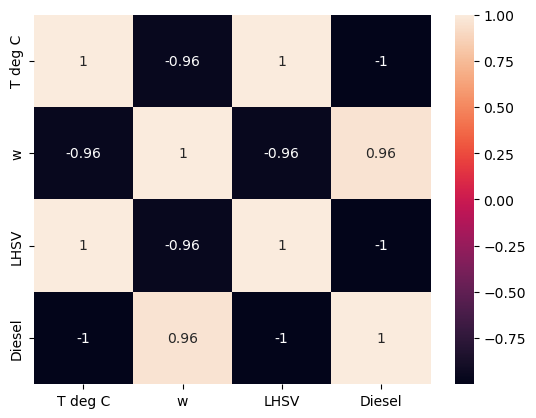

In [65]:
sns.heatmap(df[["T deg C" , "w" , "LHSV" , "Diesel"]].corr(method = "spearman") , annot = True)

Text(0.5, 1.0, 'Temperature , deg C vs LHSV , h-1')

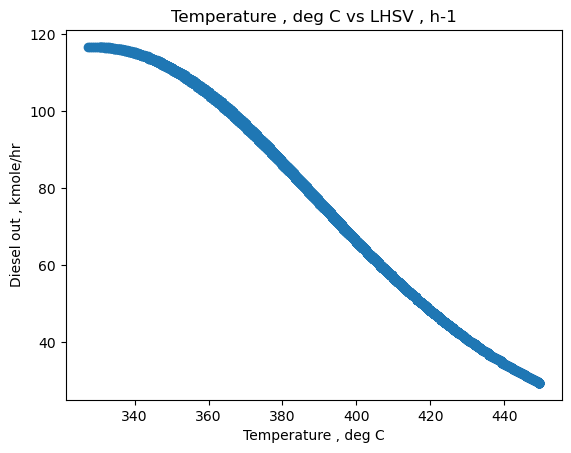

In [66]:
plt.scatter(df["T deg C"] , df["Diesel"])
plt.xlabel("Temperature , deg C")
plt.ylabel("Diesel out , kmole/hr")
plt.title("Temperature , deg C vs LHSV , h-1")

Text(0.5, 1.0, 'Diesel out , kmole/hr vs LHSV , h-1')

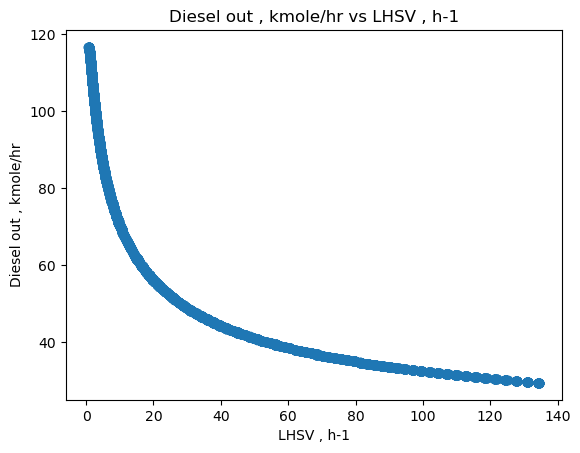

In [67]:
plt.scatter(df["LHSV"] , df["Diesel"])
plt.ylabel("Diesel out , kmole/hr")
plt.xlabel("LHSV , h-1")
plt.title("Diesel out , kmole/hr vs LHSV , h-1")

In [69]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go



# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df['T']-273.15,
    y=df['LHSV'],
    z=df['Diesel'],
    mode='markers',
    marker=dict(
        size=8,
        color=df['Diesel'],  # Color by 'Diesel'
        colorscale='Viridis',
        colorbar=dict(title='Diesel')
    )
)])

# Update layout for better view
fig.update_layout(
    scene=dict(
        xaxis_title='T',
        yaxis_title='LHSV',
        zaxis_title='Diesel'
    ),
    title='3D Scatter Plot'
)

fig.show()


In [ ]:
import pickle

with open('df_opt_LHSV', 'wb') as file:
    pickle.dump(df, file)

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
#colors = np.random.rand(268)
scatter = ax.scatter(df["T"], df["w"], df["Diesel"], marker='o', cmap='viridis')
# Add a colorbar for reference
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Color')
# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Scatter Plot')

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go



# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=df['T']-273.15,
    y=df['w'],
    z=df['Diesel'],
    mode='markers',
    marker=dict(
        size=8,
        color=df['Diesel'],  # Color by 'Diesel'
        colorscale='Viridis',
        colorbar=dict(title='Diesel')
    )
)])

# Update layout for better view
fig.update_layout(
    scene=dict(
        xaxis_title='T',
        yaxis_title='w',
        zaxis_title='Diesel'
    ),
    title='3D Scatter Plot'
)

fig.show()
